In [1]:
# Imports
import pandas as pd
import numpy as np
import doubleml as dml
from doubleml.datasets import fetch_401K

import torch
import os
import time
from functools import partial

from causal_cocycle.model import cocycle_model,cocycle_outcome_model
from causal_cocycle.optimise import *
from causal_cocycle.loss_functions import Loss
from causal_cocycle.conditioners import Lin_Conditioner,NN_RELU_Conditioner,NN_Tanh_Conditioner
from causal_cocycle.transformers import Transformer,Shift_layer,Scale_layer,RQS_layer,Inverse_layer
from causal_cocycle.helper_functions import likelihood_loss,mmd,propensity_score, empirical_KR
from causal_cocycle.kernels import *
from causal_cocycle.regression_functionals import *
from causal_cocycle.distribution_estimation import *

In [2]:
# Getting data and names
Data = fetch_401K(return_type='DataFrame')
data = Data.to_numpy()
names = np.array(list(Data[:0]))

In [3]:
# Data set-up (outside wrapper function)

# Names
covariates = ['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown', 'e401']
treatment = ["e401"]
outcome = ["net_tfa"]

# Creating tensors
X = Data[Data.columns.intersection(covariates)]
names_x = np.array(list(X[:0]))
treatment_ind = np.where(names_x == "e401")[0][0]
X = X.to_numpy()
cols_order = ([treatment_ind]+
              list(np.linspace(0,treatment_ind-1,treatment_ind).astype(int))+
              list(np.linspace(treatment_ind+1,len(X.T)-1,len(X.T)-1-treatment_ind).astype(int)))
X = X[:,cols_order]
N = len(X)
Y = Data[Data.columns.intersection(outcome)].to_numpy().reshape(N,)
X,Y = torch.tensor(X),torch.tensor(Y).view(N,1)

In [15]:
X[:,0].sum()

tensor(3682.)

In [5]:
# Method + opt set up (outside wrapper function)

# Treatment effect estimation
splits = 5
estimator = "S-estimator" 
bootstrap = False

# Cocycle training and CV
cocycle_loss = "CMMD_U"
med_heuristic_samples = 10**3
cocycle = "affine"
validation_method = "CV"
choose_best_model = "overall"
retrain = True
layers = 2
width = 32
train_val_split = 0.9
folds = 2
batch_size = 64
learn_rate = [1e-3]
scheduler = True
maxiter = 1000
miniter = 1000
weight_decay = 1e-3
RQS_bins = 8
val_batch_size =128 # REMEMBER TO CHANGE THIS!!!!!!!!!!!!!!!!!!!!!

# Propensity model training
subsample = True
subsamples = 2048
miniter_prop = 500
maxiter_prop = 500

# Setting training optimiser args
opt_args = ["learn_rate",
            "scheduler",
            "batch_size",
            "maxiter",
            "miniter",
            "weight_decay",
            "print_",
            "val_batch_size"]
opt_argvals = [learn_rate,
              scheduler,
              batch_size,
              maxiter,
              miniter,
              weight_decay,
              True,
              val_batch_size]

hyper = []
hyper_val = []

#Shorthand function calls
def NN(i,o=1,width=128,layers=2):
    return NN_Tanh_Conditioner(width = width,
                                     layers = layers, 
                                     input_dims =  i, 
                                     output_dims = o,
                                     bias = True)


In [6]:
# Storage objects
ATE_PI_term = torch.zeros(splits)
ATE_IPW = torch.zeros(splits)
ATE_DR = torch.zeros(splits)
ATT_PI_term = torch.zeros(splits)
ATT_IPW = torch.zeros(splits)
ATT_DR = torch.zeros(splits)
ATE_sq_DR = torch.zeros(splits)
ATT_sq_DR = torch.zeros(splits)

In [7]:
# Specifying dimensions
N = len(X)
D = len(X.T) - 1*(estimator=="T-estimator")
P = D - 1*(estimator=="S-estimator")

# Shuffling data
torch.manual_seed(0)
shuffled_inds = torch.randperm(Y.size()[0])
X = X[shuffled_inds]
Y = Y[shuffled_inds]

# Bootstrapping data
if bootstrap:
    bootstrap_inds = torch.randint(0,N-1,(N,))
else:
    bootstrap_inds = torch.randperm(N)
X = X[bootstrap_inds]
Y = Y[bootstrap_inds]

# Scaling data
scale_X = torch.ones(len(X.T))
for i in range(len(X.T)):
    if len(torch.unique(X[:,i])) > 2:
        scale_X[i] = X[:,i].var(0)**0.5
scale_Y = Y.var(0)**0.5
Xscale,Yscale = X/scale_X, Y/scale_Y

# Getting sample splits for DR estimation
Xsplits = get_CV_splits(Xscale,splits)
Ysplits = get_CV_splits(Yscale,splits)

In [8]:
Xscale.mean(0), Yscale.mean()

(tensor([0.3714, 3.9693, 1.5016, 1.8622, 4.6991, 0.2710, 0.6048, 0.3808, 0.2422,
         0.6352]),
 tensor(0.2842))

In [9]:
# Specifying models for cross-validation
if cocycle == "linear":
    conditioners_list = [[Lin_Conditioner(D,1)]]
    transformers_list = [Transformer([Shift_layer()])]
if cocycle == "additive":
    conditioners_list = [[NN(D,1,width,layers)]]
    transformers_list = [Transformer([Shift_layer()])]
if cocycle == "affine":
    conditioners_list = [[NN(D,1,width,layers),NN(D,1,width,layers)]]
    transformers_list = [Transformer([Shift_layer(),Scale_layer()])]
if cocycle == "TMI":
    conditioners_list = [[NN(D,1,width,layers),NN(D,1,width,layers),NN(D,3*D+2,width,layers)]]
    transformers_list = [Transformer([Shift_layer(),Scale_layer(),RQS_layer(RQS_bins)])]
    
models_validation = []
for m in range(len(conditioners_list)):
    models_validation.append(cocycle_model(conditioners_list[m],transformers_list[m]))
hyper_args = [hyper]*len(conditioners_list)
hyper_argvals = [hyper_val]*len(conditioners_list)

In [10]:
# Getting loss functon (using CMMD_V as scalable for validation)
loss_fn =  Loss(loss_fn = cocycle_loss,kernel = [gaussian_kernel(torch.ones(1),1)]*2)
loss_fn_val =  Loss(loss_fn = "CMMD_V",kernel = [gaussian_kernel(torch.ones(1),1)]*2)
loss_fn.median_heuristic(Xscale,Yscale,subsamples = med_heuristic_samples)
loss_fn_val.median_heuristic(Xscale,Yscale,subsamples = med_heuristic_samples)

/nfs/ghome/live/danceh/Cocycles/causal_cocycle/loss_functions.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706712279749/work/torch/csrc/utils/tensor_new.cpp:261.)
  batch_inds = torch.tensor([np.random.choice(ind_list,subsamples)]).long().view(subsamples,)


## S-estimation (PI)

In [11]:
if estimator == "S-estimator":

    # Getting plug-in estimator
    final_model_PI,val_losses_PI = validate(models_validation,
                                         loss_fn,
                                         Xscale,
                                         Yscale,
                                         loss_fn_val,
                                         validation_method,
                                         train_val_split,
                                         opt_args,
                                         opt_argvals,
                                         hyper_args,
                                         hyper_argvals,
                                         choose_best_model,
                                         retrain)
    
    # Getting interventional inputs
    X1,X0 = Xscale*1,Xscale*1
    X1[:,0],X0[:,0] = 1,0
    treated = Xscale[:,0]==1
    
    # Getting potential outcomes and plug-in estimator
    Y1scale = final_model_PI.cocycle(X1,Xscale,Yscale).detach()
    Y0scale = final_model_PI.cocycle(X0,Xscale,Yscale).detach()
    ATE_PI = (Y1scale-Y0scale).mean()*scale_Y
    ATT_PI = (Y1scale-Y0scale)[treated].mean()*scale_Y
    Var_ATE_PI = (Y1scale-Y0scale).var()*scale_Y**2/len(Y1scale)
    Var_ATT_PI = (Y1scale-Y0scale)[treated].var()*scale_Y**2/treated.sum()

Training loss last 10 avg is : tensor(-0.5084)
99.0  % completion
Finished optimising final model


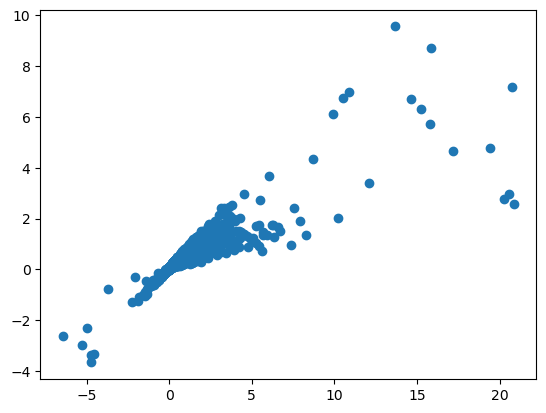

In [12]:
plt.scatter(Y0scale,Y1scale - Y0scale);

In [14]:
(Y1scale-Y0scale).mean()*scale_Y

tensor([6491.2915])

In [15]:
(Y1scale-Y0scale)*scale_Y

tensor([[22113.2695],
        [ 1124.8751],
        [ 1206.2394],
        ...,
        [18052.5000],
        [   93.4471],
        [  895.5991]])

In [13]:
(((Y1scale-Y0scale)*scale_Y).var()/len(Y1scale))**0.5

tensor(78.7303)

## S-estimation (DR)

In [ ]:
# Doing ATE estimation
if estimator == "S-estimator":
    val_losses_DR = []
    weights1,weights0 = [],[]
    for k in range(splits):

        # Getting dataset
        Xtrain,Ytrain = Xsplits[k][0],Ysplits[k][0]
        Xtest,Ytest = Xsplits[k][1],Ysplits[k][1]
        treated_train,control_train = Xtrain[:,0]==1,Xtrain[:,0]==0
        treated_test,control_test = Xtest[:,0]==1,Xtest[:,0]==0

        # Getting model for kth split
        final_model_DR,val_losses = validate(models_validation,
                                         loss_fn,
                                         Xtrain,
                                         Ytrain,
                                         loss_fn_val,
                                         validation_method,
                                         train_val_split,
                                         opt_args,
                                         opt_argvals,
                                         hyper_args,
                                         hyper_argvals,
                                         choose_best_model,
                                         retrain)
        val_losses_DR.append(val_losses)
        
        # Getting interventional inputs
        Xtest1,Xtest0 = Xtest*1,Xtest*1
        Xtest1[:,0],Xtest0[:,0] = 1,0
    
        # Getting potential outcomes and plug-in estimator
        EY1test = final_model_DR.cocycle_outer(Xtest1,Xtrain,Ytrain).detach().mean(1)
        EY0test = final_model_DR.cocycle_outer(Xtest0,Xtrain,Ytrain).detach().mean(1)
        ATE_PI_term[k] = (EY1test-EY0test).mean()
        ATT_PI_term[k] = (Ytest[:,0]-EY0test)[treated_test].mean()
        v_ATE_DR = (EY1test-EY0test)
        v_ATT_DR = (Ytest[:,0]-EY0test)*Xtest[:,1]/treated_test.float().mean()
           
        
        # Estimating propensity model
        kernel = exponential_kernel(lengthscale = torch.ones(P, requires_grad = True),scale = 1)
        regressor = NW_functional(kernel,reg = 1e-4)
        propensity_model = Conditional_Expectation_Regressor(regressor)
        losses = propensity_model.optimise(Xtrain[:,1:],Xtrain[:,:1].float(),
                                    subsample = subsample,
                                    miniter = miniter_prop,
                                    maxiter = maxiter_prop,
                                    subsamples = subsamples,
                                    nfold = folds,
                                    print_ = True)

        # Getting IPW weights and estimator
        Probs = propensity_model.forward(Xtrain[:,:1],Xtrain[:,1:].float(),Xtest[:,1:].float()).detach()
        weights1.append(Xtest[:,:1]/Probs)
        weights0.append((1-Xtest[:,:1])/(1-Probs))
        ATE_IPW[k] = ((weights1[k]-weights0[k])*Ytest).mean()
        v_ATE_DR += (weights1[k]-weights0[k])[:,0]*Ytest[:,0]

        # Getting conditional expectations and DR estimator
        ATE_DR[k] = ATE_PI_term[k]+ ATE_IPW[k] + ((weights0[k][:,0]*EY0test - weights1[k][:,0]*EY1test)).mean()
        ATT_DR[k] = ATT_PI_term[k] - ((weights0[k]*Probs)[:,0]*(Ytest-EY0test)).mean()/treated.float().mean()
        v_ATE_DR += (weights0[k][:,0]*EY0test - weights1[k][:,0]*EY1test)
        v_ATT_DR -= ((weights0[k]*Probs)[:,0]*(Ytest[:,0]-EY0test))/treated_test.float().mean()
        ATE_sq_DR[k] = (v_ATE_DR**2).mean()
        ATT_sq_DR[k] = (v_ATT_DR**2).mean()
    
ATE_PI_term *= scale_Y
ATE_IPW *= scale_Y
ATE_DR *= scale_Y
ATT_PI_term *= scale_Y
ATT_IPW *= scale_Y
ATT_DR *= scale_Y

## T-estimation (PI)

In [ ]:
if estimator == "T-estimator":

    # Getting dataset
    treated,control = Xscale[:,0]==1,Xscale[:,0]==0

    #  Splitting dataset into treated and control
    Y_1,X_1 = Yscale[treated], Xscale[treated,1:]
    Y_0,X_0 = Yscale[control], Xscale[control,1:]
    
    # T-estimation
    final_model1,val_losses1 = validate(models_validation,
                                         loss_fn,
                                         X_1,
                                         Y_1,
                                         loss_fn_val,
                                         validation_method,
                                         train_val_split,
                                         opt_args,
                                         opt_argvals,
                                         hyper_args,
                                         hyper_argvals,
                                         choose_best_model,
                                         retrain)
    
    final_model0,val_losses0 = validate(models_validation,
                                         loss_fn,
                                         X_0,
                                         Y_0,
                                         loss_fn_val,
                                         validation_method,
                                         train_val_split,
                                         opt_args,
                                         opt_argvals,
                                         hyper_args,
                                         hyper_argvals,
                                         choose_best_model,
                                         retrain)
    val_losses_PI = [val_losses1,val_losses0]
    
    # Estimating KR transport
    U_1 = final_model1.inverse_transformation(X_1,Y_1).detach()
    U_0 = final_model0.inverse_transformation(X_0,Y_0).detach()
    KR_map = empirical_KR(U_0,U_1)

    # Getting base distribution test samples for entire fold
    U1,U0 = torch.zeros((len(treated),1)), torch.zeros((len(treated),1))
    U1[treated],U0[control] = U_1,U_0
    U1[control],U0[treated] = KR_map.forward(U_0),KR_map.forward(U_1)

    # Getting potential outcomes and plug-in estimator
    Y1scale =  final_model1.transformation(Xscale[:,1:],U1).detach()
    Y0scale =  final_model0.transformation(Xscale[:,1:],U0).detach()
    ATE_PI = (Y1scale-Y0scale).mean()*scale_Y
    ATT_PI = (Y1scale-Y0scale)[treated].mean()*scale_Y


In [ ]:
    # Estimating KR transport
    U_1 = final_model1[0].inverse_transformation(X_1,Y_1).detach()
    U_0 = final_model0[0].inverse_transformation(X_0,Y_0).detach()
    KR_map = empirical_KR(U_0,U_1)

    # Getting base distribution test samples for entire fold
    U1,U0 = torch.zeros((len(treated),1)), torch.zeros((len(treated),1))
    U1[treated],U0[control] = U_1,U_0
    U1[control],U0[treated] = KR_map.forward(U_0),KR_map.forward(U_1)

    # Getting potential outcomes and plug-in estimator
    Y1scale =  final_model1[0].transformation(Xscale[:,1:],U1).detach()
    Y0scale =  final_model0[0].transformation(Xscale[:,1:],U0).detach()
    ATE_PI = (Y1scale-Y0scale).mean()*scale_Y
    ATT_PI = (Y1scale-Y0scale)[treated].mean()*scale_Y

In [ ]:
# Estimating KR transport
U_1 = final_model1.inverse_transformation(X_1,Y_1).detach()
U_0 = final_model0.inverse_transformation(X_0,Y_0).detach()
KR_map = empirical_KR(U_0,U_1)

# Getting base distribution test samples for entire fold
U1,U0 = torch.zeros((len(treated),1)), torch.zeros((len(treated),1))
U1[treated],U0[control] = U_1,U_0
U1[control],U0[treated] = KR_map.forward(U_0),KR_map.forward(U_1)

# Getting potential outcomes and plug-in estimator
Y1scale =  final_model1.transformation(Xscale[:,1:],U1).detach()
Y0scale =  final_model0.transformation(Xscale[:,1:],U0).detach()
ATE_PI = (Y1scale-Y0scale).mean()*scale_Y
ATT_PI = (Y1scale-Y0scale)[treated].mean()*scale_Y

In [ ]:
#bins_scale=50
#plt.hist(U0[control].numpy(), bins = int(control.sum()/bins_scale),alpha = 1);
#plt.hist(U0[treated].numpy(), bins = int(treated.sum()/bins_scale),alpha = 0.5);

In [ ]:
if estimator == "T-estimator":
    Utrain1_splits,Utrain0_splits = [],[]
    val_losses_DR = []
    for k in range(splits):

        # Getting dataset
        Xtrain,Ytrain = Xsplits[k][0],Ysplits[k][0]
        Xtest,Ytest = Xsplits[k][1],Ysplits[k][1]
        treated_train,control_train = Xtrain[:,0]==1,Xtrain[:,0]==0
        treated_test,control_test = Xtest[:,0]==1,Xtest[:,0]==0
    
        #  Splitting dataset into treated and control
        Y_1train,X_1train = Ytrain[treated_train], Xtrain[treated_train,1:]
        Y_0train,X_0train = Ytrain[control_train], Xtrain[control_train,1:]
        Y_1test,X_1test = Ytest[treated_test], Xtest[treated_test,1:]
        Y_0test,X_0test = Ytest[control_test], Xtest[control_test,1:]
        
        # T-estimation
        final_model1,val_losses1 = validate(models_validation,
                                             loss_fn,
                                             X_1train,
                                             Y_1train,
                                             loss_fn_val,
                                             validation_method,
                                             train_val_split,
                                             opt_args,
                                             opt_argvals,
                                             hyper_args,
                                             hyper_argvals,
                                             choose_best_model,
                                             retrain)
        
        final_model0,val_losses0 = validate(models_validation,
                                             loss_fn,
                                             X_0train,
                                             Y_0train,
                                             loss_fn_val,
                                             validation_method,
                                             train_val_split,
                                             opt_args,
                                             opt_argvals,
                                             hyper_args,
                                             hyper_argvals,
                                             choose_best_model,
                                             retrain)
        val_losses_DR.append([val_losses1,val_losses0])
        
        # Estimating KR transport
        U_1train = final_model1.inverse_transformation(X_1train,Y_1train).detach()
        U_0train = final_model0.inverse_transformation(X_0train,Y_0train).detach()
        KR_map = empirical_KR(U_0train,U_1train)

        # Getting base distribution test samples for entire fold
        Utrain1,Utrain0 = torch.zeros((len(treated_train),1)), torch.zeros((len(treated_train),1))
        Utrain1[treated_train],Utrain0[control_train] = U_1train,U_0train
        Utrain1[control_train],Utrain0[treated_train] = KR_map.forward(U_0train),KR_map.forward(U_1train)

        # Saving samples for re-use
        Utrain1_splits.append(Utrain1)
        Utrain0_splits.append(Utrain0)
        
        # Getting potential outcomes and plug-in estimator
        EY1test =  final_model1.transformation_outer(Xtest[:,1:],Utrain1).detach().mean(1)
        EY0test =  final_model0.transformation_outer(Xtest[:,1:],Utrain0).detach().mean(1)
        ATE_PI_term[k] = (EY1test-EY0test).mean()
        ATT_PI_term[k] = (Ytest[:,0]-EY0test).mean()

        # Estimating propensity model
        kernel = exponential_kernel(lengthscale = torch.ones(P, requires_grad = True),scale = 1)
        regressor = NW_functional(kernel)
        propensity_model = Conditional_Expectation_Regressor(regressor)
        losses = propensity_model.optimise(Xtrain[:,1:],Xtrain[:,:1].float(),
                                    subsample = subsample,
                                    miniter = miniter_prop,
                                    maxiter = maxiter_prop,
                                    subsamples = subsamples,
                                    nfold = folds)

        # Getting IPW weights and estimator
        Probs = propensity_model.forward(Xtrain[:,:1],Xtrain[:,1:].float(),Xtest[:,1:].float()).detach()
        weights1.append(Xtest[:,:1]/Probs)
        weights0.append((1-Xtest[:,:1])/(1-Probs))
        ATE_IPW[k] = ((weights1[k]-weights0[k])*Ytest).mean()


        # Getting conditional expectations and DR estimator
        ATE_DR[k] = ATE_PI_term[k]+ ATE_IPW[k] + ((weights0[k][:,0]*EY0test - weights1[k][:,0]*EY1test)).mean()
        ATT_DR[k] = ATT_PI_term[k] - ((weights0[k]*Probs)[:,0]*(Ytest-EY0test)).mean()/treated_test.float().mean()

    ATE_PI_term *= scale_Y
    ATE_IPW *= scale_Y
    ATE_DR *= scale_Y
    ATT_PI_term *= scale_Y
    ATT_IPW *= scale_Y
    ATT_DR *= scale_Y

## ETQ estimation (effect of treatment on quantile, not quantile treatment effect!)

In [ ]:
# Counterfactual regression
treated,control = Xscale[:,0]==1,Xscale[:,0]==0
PPEQ_threshold = 1000 

# Set up
functional_ETQ = LL_functional
functional_PPEQ = NW_functional
kernel = gaussian_kernel
subsample = False
kx = kernel(lengthscale = 1)
regressor_ETQ = functional_ETQ(kx)
regressor_PPEQ = functional_PPEQ(kx)
CE_ETQ = Conditional_Expectation_Regressor(regressor_ETQ)
CE_PPEQ = Conditional_Expectation_Regressor(regressor_PPEQ)

# Hypergrid
if functional_ETQ != KRR_functional:
    hyper_ls = 2**torch.linspace(-5,5,10)
    hyper_grid = [[hyper_ls[h]] for h in range(len(hyper_ls))]
else:
    hyper_lambda = 2**torch.linspace(-10,0,5)
    hyper_ls = 2**torch.linspace(-5,5,5)
    hyper_grid_lambda = hyper_lambda.repeat(len(hyper_ls))
    hyper_grid_ls = torch.repeat_interleave(hyper_ls,len(hyper_lambda)) 
    hyper_grid = [[hyper_grid_ls[h],hyper_grid_lambda[h]] for h in range(len(hyper_grid_lambda))]

# Doing CV over hypers
CE_ETQ.CVgridsearch(Y0scale,(Y1scale-Y0scale),
                        nfold = folds, 
                        subsample = subsample,
                        subsamples = subsamples,
                        hyper_grid = hyper_grid)

# Hypergrid
if functional_ETQ != KRR_functional:
    hyper_ls = 2**torch.linspace(-5,5,10)
    hyper_grid = [[hyper_ls[h]] for h in range(len(hyper_ls))]
else:
    hyper_lambda = 2**torch.linspace(-10,0,5)
    hyper_ls = 2**torch.linspace(-5,5,5)
    hyper_grid_lambda = hyper_lambda.repeat(len(hyper_ls))
    hyper_grid_ls = torch.repeat_interleave(hyper_ls,len(hyper_lambda)) 
    hyper_grid = [[hyper_grid_ls[h],hyper_grid_lambda[h]] for h in range(len(hyper_grid_lambda))]

# Doing CV over hypers
CE_PPEQ.CVgridsearch(Y0scale,((Y1scale-Y0scale)>=PPEQ_threshold/scale_Y).float(),
                        nfold = folds, 
                        subsample = subsample,
                        subsamples = subsamples,
                        hyper_grid = hyper_grid)

In [ ]:
# Getting quantiles:
quantiles = torch.linspace(0.1,0.9,90)
Y0quants = torch.quantile(Y0scale,quantiles)[:,None]
ETQ = CE_ETQ.forward((Y1scale-Y0scale),Y0scale,Y0quants).detach()*scale_Y
PPEQ = CE_PPEQ.forward(((Y1scale-Y0scale)>=PPEQ_threshold/scale_Y).float(),Y0scale,Y0quants).detach()

In [ ]:
plt.plot(quantiles,PPEQ);
plt.show()
plt.plot(quantiles,ETQ);

In [ ]:
# Getting quantiles (treated and control):
quantiles = torch.linspace(0.01,0.99,99)
Yquants_control = torch.quantile(Yscale[control],quantiles)[:,None]
Yquants_treated = torch.quantile(Yscale[treated],quantiles)[:,None]

ETQ1 = CE.forward((Y1scale[treated]-Y0scale[treated]),Yscale[treated],Yquants_treated).detach()*scale_Y
ETQ0 = CE.forward((Y1scale[control]-Y0scale[control]),Yscale[control],Yquants_control).detach()*scale_Y

In [ ]:
results = {"ATE_PI" : ATE_PI,
           "ATE_PI_term" : ATE_PI_term,
           "ATE_IPW" : ATE_IPW,
           "ATE_DR" : ATE_DR,
           "ATT_PI" : ATT_PI,
           "ATT_PI_term" : ATT_PI_term,
           "ATT_DR" : ATT_DR,
           "ETQ" : ETQ,
           "PPEQ" : PPEQ,
           "val_loss_PI",val_losses_PI,
           "val_loss_DR",val_losses_DR}